# Spectral Clustering


In this exercise, you will implement spectral clustering and try it on diffent kinds of data, for instance:

* N-blob: Random points in $\mathbb{R}^2$ according to N Gaussian distributions with different means;

* Two moons: Random points shaped as two intertwined moons; 

* Point and circle: random points from a concentrated Gaussian point in the middle and a wide circle around it.

The first step after generating the data is to construct a graph and, for that, we need a similarity function. In this exercise we will use the following similarity:

$$
d(x_i, x_j) = \exp\left(-\frac{||x_i-x_j||_2^2}{2\sigma^2}\right)
$$

Using this similarity, we can compute the weight matrix W representing the graph, compute the graph Laplacian L and finally use its eigenvectors for clustering.


## Setup

In [1]:
import os


from utils import (
    min_span_tree,
    plot_clustering_result,
    plot_clusters,
    plot_edges_and_points,
    plot_graph_matrix,
    plot_the_bend,
)

%load_ext autoreload
%autoreload 2

## Helper function 

Function to draw without edges

In [2]:
def plot_edges_and_points_no_edges(X, Y, W, title=""):
    colors = ["go-", "ro-", "co-", "ko-", "yo-", "mo-"]
    n = len(X)
    for i in range(n):
        plt.plot(X[i, 0], X[i, 1], colors[int(Y[i])])
    plt.title(title)
    plt.axis("equal")

## Generating the data

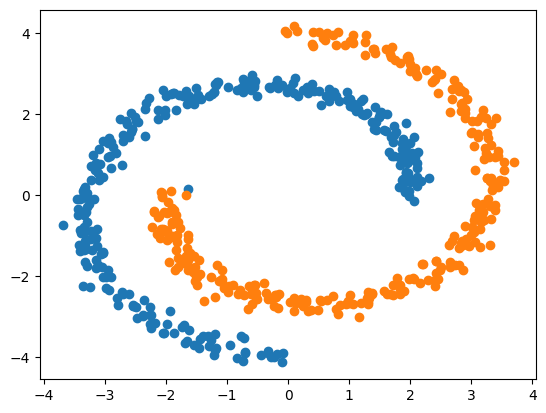

Signature: worst_case_blob(num_samples, delta=5)
Docstring:
Generates a single blob.

:param num_samples: number of samples to create in the blob
:param delta:
:return: X,  (num_samples, 2) matrix of 2-dimensional samples
         Y,  (num_samples, ) vector of "true" cluster assignment
File:      ~/GML/spectral_clustering/generate_data.py
Type:      function


In [3]:
# Example

for fn in [two_moons]:  #  try also [worst_case_blob, point_and_circle, blobs]
    X, Y = fn(num_samples=600)
    plot_clusters(X, Y, fignum=str(fn))
    
# You can check the documentation of each function to see the optional parameters, e.g.:
worst_case_blob?

## Building similarity graph

In [4]:
def build_similarity_graph(X, var=1.0, eps=0.0, k=0):
    """
    TO BE COMPLETED.

    Computes the similarity matrix for a given dataset of samples.
    If k=0, builds epsilon graph.
    Otherwise, builds kNN graph.

    Parameters
    ----------
    X : numpy array
        (n x m) matrix of m-dimensional samples
    var : double
        the sigma value for the exponential function, already squared
    eps : double
        threshold for epsilon graphs
    k : int
        The number of neighbours k for k-nn. If zero, use epsilon-graph

    Returns
    -------
        W: (n x n) dimensional matrix representing the weight matrix of the graph
    """
    n = X.shape[0]
    W = np.zeros((n, n))

    """
    Build similarity graph, before threshold or kNN
    similarities: (n x n) matrix with similarities between all possible couples of points.
    The similarity function is d(x,y)=exp(-||x-y||^2/(2*var))
    """

    similarities = np.exp(
        -np.linalg.norm(X[None, :, :] - X[:, None, :], axis=-1) ** 2 / (2 * var)
    )

    # If epsilon graph
    if k == 0:
        """
        compute an epsilon graph from the similarities
        for each node x_i, an epsilon graph has weights
        w_ij = d(x_i,x_j) when w_ij >= eps, and 0 otherwise
        """
        mask = similarities >= eps
        W[mask] = similarities[mask]

    # If kNN graph
    elif k != 0:
        """
        compute a k-nn graph from the similarities
        for each node x_i, a k-nn graph has weights
        w_ij = d(x_i,x_j) for the k closest nodes to x_i, and 0
        for all the k-n remaining nodes
        Remember to remove self similarity and
        make the graph undirected
        """
        similarities -= np.diag(np.diag(similarities))
        for i in range(n):
            closest_points = np.argsort(similarities[i])[::-1][:k]
            W[i, closest_points] = similarities[i, closest_points]
        # for a symmetric W
        W += W.T

    return W


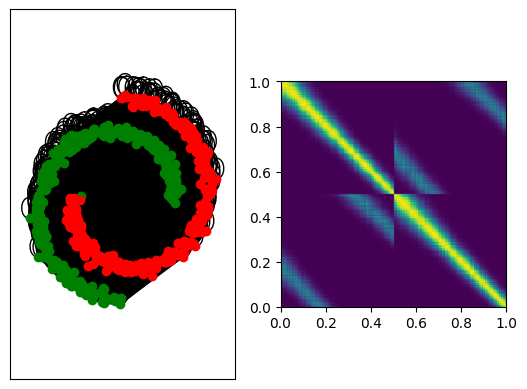

In [6]:
# Example

W = build_similarity_graph(X)
W[0, 599] = 1  # add two placeholder edges to reproduce example picture
W[10, 500] = 1  #


plot_graph_matrix(X, Y, W)  # shows the graph and the visualization of W


## Computing the Laplacian

In [7]:
def build_laplacian(W, laplacian_normalization="unn"):
    """
    Compute graph Laplacian.

    Parameters
    ----------
    W : numpy array
        Adjacency matrix (n x n)
    laplacian_normalization : str
        String selecting which version of the laplacian matrix to construct.
            'unn':  unnormalized,
            'sym': symmetric normalization
            'rw':  random-walk normalization

    Returns
    -------
    L: (n x n) dimensional matrix representing the Laplacian of the graph
    """
    # L = np.zeros(W.shape)
    n = W.shape[0]
    D = np.diag(np.sum(W, axis=1))
    if laplacian_normalization == "unn":
        L = D - W
    elif laplacian_normalization == "sym":
        D_inv_sqrt = np.sqrt(np.linalg.inv(D))
        L = np.eye(n) - D_inv_sqrt @ W @ D_inv_sqrt
    elif laplacian_normalization == "rw":
        D_inv = np.linalg.inv(D)
        L = np.eye(n) - D_inv @ W
    return L


## Clustering

In [9]:
def choose_eigenvalues(eigenvalues):
    """
    Function to choose the indices of which eigenvalues to use for clustering.

    :param eigenvalues: sorted eigenvalues (in ascending order)
    :return: indices of the eigenvalues to use
    """
    gaps = eigenvalues[1:] - eigenvalues[:-1]
    last_index = 0
    threshold = 0.2
    for idx, gap in enumerate(gaps):
        if gap > threshold:
            last_index = idx + 1
    return list(range(last_index + 1))


def spectral_clustering(L, chosen_eig_indices=None, num_classes=2):
    """
    Parameters
    ----------
    L : numpy array
        Graph Laplacian (standard or normalized)
    choosen_eig_indices : list or None
        Indices of eigenvectors to use for clustering.
        If None, use adaptive choice of eigenvectors.
    num_classes : int
        Number of clusters to compute (defaults to 2)


    Returns
    -------
    Y : numpy array (num_samples, )
        Cluster assignments
    """

    """
    Use the function scipy.linalg.eig or the function scipy.sparse.linalg.eigs to compute:
    U = (n x n) eigenvector matrix           (sorted)
    E = (n x n) eigenvalue diagonal matrix   (sorted)
    """
    E, U = scipy.linalg.eig(
        L,
    )
    indices = np.argsort(E.real)
    U = U[:, indices].real
    E = E[indices].real
    if chosen_eig_indices is None:
        chosen_eig_indices = choose_eigenvalues(E[:15])
    """
    compute the clustering assignment from the eigenvectors        
    Y = (n x 1) cluster assignments in [0,1,...,num_classes-1]                   
    """
    # Y = np.zeros(L.shape[0])
    kmeans = KMeans(n_init="auto", n_clusters=num_classes)
    Y = kmeans.fit_predict(U[:, chosen_eig_indices].real)
    return Y


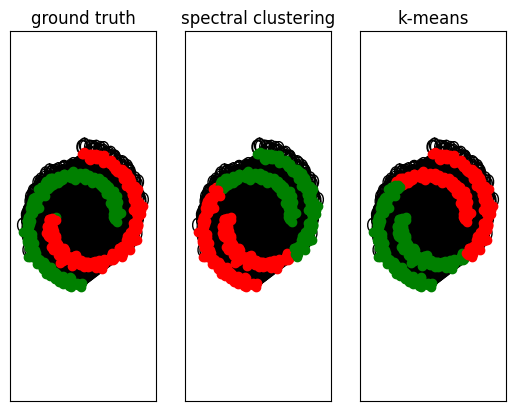

In [11]:
# Example

num_classes = 2
L = build_laplacian(W)
Y_rec = spectral_clustering(L, num_classes=num_classes, chosen_eig_indices=[1, 2])

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes, n_init="auto").fit_predict(X))


## Parameter sensitivity 

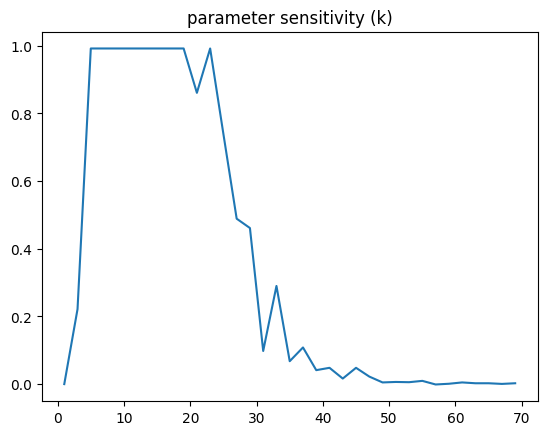

In [12]:
def parameter_sensitivity(parameter_type="k"):
    """
    TO BE COMPLETED.

    A function to test spectral clustering sensitivity to parameter choice.
    """
    # the number of samples to generate
    num_samples = 500

    """
    Choose parameters
    """
    var = 2  # exponential_euclidean's sigma^2
    laplacian_normalization = "rw"
    chosen_eig_indices = list(range(1, 2))

    """
    Choose candidate parameters
    """
    # parameter_type = "k"  # choose between 'k' or 'eps'
    if parameter_type == "k":
        parameter_candidate = list(
            range(1, 70, 2)
        )  # the number of neighbours for the graph (if 'k')
    else:
        parameter_candidate = np.linspace(0, 2, 30)  # the epsilon threshold (if 'eps')
    parameter_performance = []

    for parameter in parameter_candidate:
        # Generate data
        X, Y = two_moons(num_samples, 1, 0.02)
        num_classes = len(np.unique(Y))

        parameter_wrap = {parameter_type: parameter}

        W = build_similarity_graph(X, **parameter_wrap, var=var)
        try:
            L = build_laplacian(W, laplacian_normalization)

            Y_rec = spectral_clustering(L, chosen_eig_indices, num_classes)

            parameter_performance += [skm.adjusted_rand_score(Y, Y_rec)]
            # if parameter_performance[-1] > 0.9:
            #     print(parameter)
            #     plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))
        except scipy.linalg.LinAlgError as E:
            parameter_performance += [0]
    plt.figure()
    plt.plot(parameter_candidate, parameter_performance)
    plt.title(f"parameter sensitivity ({parameter_type})")
    plt.show()


parameter_sensitivity()


## Image segmentation

In [13]:
def image_segmentation(input_img="four_elements.bmp", num_classes=5):
    """
    TO BE COMPLETED

    Function to perform image segmentation.

    :param input_img: name of the image file in /data (e.g. 'four_elements.bmp' or 'fruit_salad.bmp')
    """
    filename = os.path.join("data", input_img)

    X = io.imread(filename)
    X = (X - np.min(X)) / (np.max(X) - np.min(X))

    im_side = np.size(X, 1)
    Xr = X.reshape(im_side**2, 3)
    """
    Y_rec should contain an index from 0 to c-1 where c is the     
     number of segments you want to split the image into          
    """

    """
    Choose parameters
    """
    var = 1
    k = 23
    laplacian_normalization = "rw"
    chosen_eig_indices = list(range(1, 7))

    W = build_similarity_graph(Xr, var=var, k=k)
    L = build_laplacian(W, laplacian_normalization)
    Y_rec = spectral_clustering(L, chosen_eig_indices, num_classes=num_classes)

    plt.figure()

    plt.subplot(1, 2, 1)
    plt.imshow(X)

    plt.subplot(1, 2, 2)
    Y_rec = Y_rec.reshape(im_side, im_side)
    plt.imshow(Y_rec)

    plt.show()



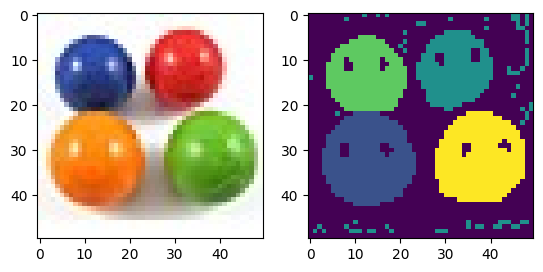

In [14]:
image_segmentation(num_classes=5)


# Questions

### Q1.1: What is the purpose of the option parameter in `worst_case_blob`?

The goal of the `delta` parameter in `worst_case_blob` is to create an outlier in a 2D Gaussian distribution $\mathcal{N}(0, 0.3)$. This outlier is translated of $x=\texttt{delta}$ in the the plane from the furthest point, and is located at $y=0$.

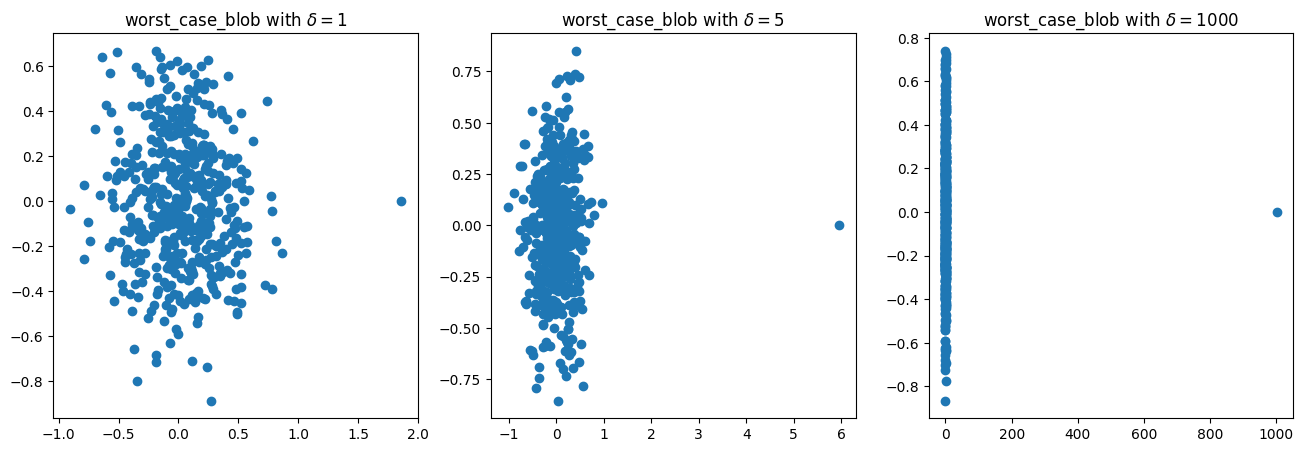

In [15]:
plt.rcParams["text.usetex"] = False

fig, axs = plt.subplots(1, 3, figsize=(16, 5))
for index, delta in enumerate([1, 5, 1000]):
    X, Y = worst_case_blob(500, delta=delta)
    axs[index].plot(X[:, 0], X[:, 1], "o")
    axs[index].set_title(rf"worst_case_blob with $\delta={{{delta}}}$")


### Q1.2: While varying the parameter of `worst_case_blob`, try to select a value of $\epsilon$ that keeps the graph connected (the function `min_span_tree` can help you). What happens? Can you tell when it is a bad idea to use this approach?

We notice that the outlier, located at $(0, \delta)$ is roughly $\delta+1$ far away from the other points. The $+1$ comes from the fact that 99% of points are located in $[-3\times 0.3 \ , \ 3\times 0.3]^2$. 

Thus, in order to have the graph connected (ie the outlier is connected to the other points), we want 

$$
e^{-\frac{(\delta+1)^2}{2\sigma^2}} \geq \epsilon
$$

with $\sigma^2$ the variance used in the similarity computation. Here $\sigma=1$.

In [16]:
delta = 1
opt_epsilon = np.exp(-((delta + 1) ** 2) / 2)
X, Y = worst_case_blob(500, delta=delta)
W = build_similarity_graph(X, eps=opt_epsilon)
tree = min_span_tree(W)
print(
    "When using delta = {}, and epsilon = {:.2f} The graph is completely connected.".format(
        delta, opt_epsilon
    )
)
assert np.sum(tree) == len(tree) - 1  # checks if the graph is completely connected


When using delta = 1, and epsilon = 0.14 The graph is completely connected.


When using an $\epsilon$ thresholding, if we connect the outlier to at least one other points, then all normal points would be connected. This would result in a completely connected graphs which has some drawbacks: it has a huge time and space complexity and doesn't preserve local properties.

### Q1.3: Is it important to build a connected graph? Compare k-NN to $\epsilon$-graphs with respect to the difficulty of building a connected graph.

It is important to build a connected graphs. Otherwise, with a very small $\epsilon$, the thresholding would give us 2 connected components, with one only made of the outlier. In that case, the clustering is obvious.


In [17]:
from time import time


def sparse_memory_usage(mat):
    try:
        return mat.data.nbytes + mat.indptr.nbytes + mat.indices.nbytes
    except AttributeError:
        return -1


# building an epsilon graph
start = time()
W_epsilon = scipy.sparse.csr_array(build_similarity_graph(X, eps=0))
elpased_epsilon_builing = time() - start

# building an k-NN graph
start = time()
W_knn = scipy.sparse.csr_array(build_similarity_graph(X, k=7))
elpased_knn_builing = time() - start

print(
    "Time elapsed for building an epsilon graph: {:.2f}ms".format(
        elpased_epsilon_builing * 100
    )
)
print(
    "Time elapsed for building a knn graph: {:.2f}ms".format(elpased_knn_builing * 100)
)

print(
    "Space taken by an epsilon graph: {:.2f}ko".format(
        sparse_memory_usage(W_epsilon) / 1000
    )
)
print("Space taken by a knn graph: {:.2f}ko".format(sparse_memory_usage(W_knn) / 1000))


Time elapsed for building an epsilon graph: 3.54ms
Time elapsed for building a knn graph: 5.05ms
Space taken by an epsilon graph: 3002.00ko
Space taken by a knn graph: 53.10ko


The above cell shows that it is twice longer to build a k-NN graph, while it is 70 times lighter.

We understand that in dense data, the $\epsilon$ graph often results in completely connected graphs, while a k-NN graphs has always the same amount of information retained.

However, when dealing with very different clusters, it may be very difficult to build a connected graph using the K-NN method. Indeed, to build a connected graph, we must:
1. set $\epsilon$ corresponding the largest distance between 2 clusters.
2. set $k$ to the maximum number of element per cluster + 1

Below is a representation of 2 clusters. Either condition (1. or 2.) may be hard to obtain.

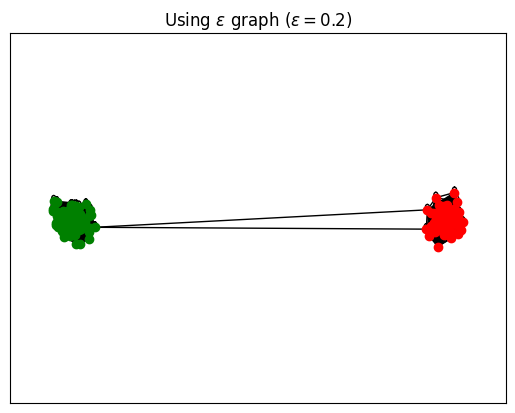

In [18]:
X, Y = blobs(200, n_blobs=2, blob_var=0.05, surplus=0)
W_epsilon = build_similarity_graph(X, eps=0.2)
W_knn = build_similarity_graph(X, k=20)
plot_edges_and_points(X, Y, W_epsilon, r"Using $\epsilon$ graph ($\epsilon=0.2$)")


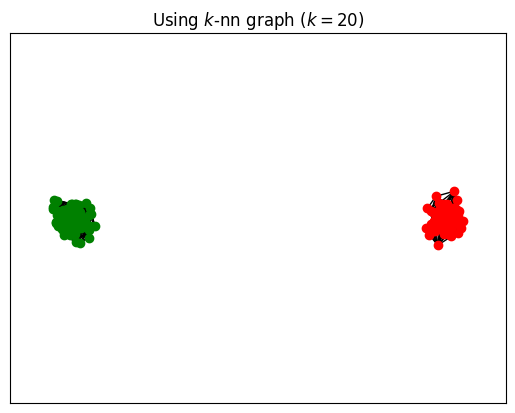

In [19]:
plot_edges_and_points(X, Y, W_knn, r"Using $k$-nn graph ($k=20$)")


### Q2.1: Build a graph starting from the data generated in `blobs`, and keep the graph connected. Use `spectral_clustering` to cluster the data. Motivate your choice on which eigenvectors to use and how you computed the clustering assignments from the eigenvectors. Now compute a similar clustering using the built-in k-means and compare the results.

We use an $\epsilon$ graph, to connect all the nodes together. Indeed, in this situation, a k-NN graph would need us more interpretation to estimate how many elements are in a cluster to connect the graph. This type of information is usually hidden.

We choose a normalized laplacian as the clustering appears smoother.

In order to cluster, we use the 2nd eigenvector, as it is the solution to the spectral clustering problem with relaxed balanced cuts. However, in order to help the clustering using the 2nd eigenvector, we also use the 3rd eigenvector. In that case, we obtain better results.


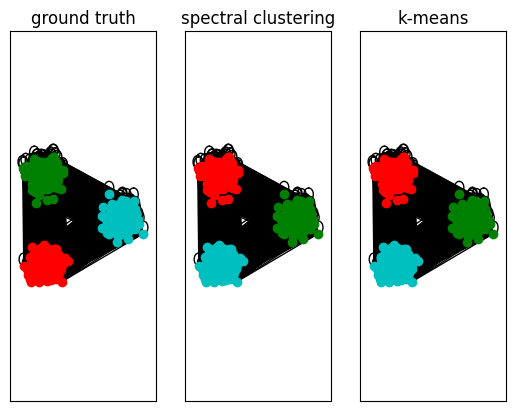

In [144]:
X, Y = blobs(num_samples=600, n_blobs=3)

W = build_similarity_graph(X, eps=0)
L = build_laplacian(W, "rw")
Y_rec_spectral = spectral_clustering(L, num_classes=3, chosen_eig_indices=[1, 2])

Y_rec_knn = KMeans(n_clusters=3, n_init="auto").fit_predict(X)

plot_clustering_result(X, Y, W, Y_rec_spectral, Y_rec_knn)


We also compare the results with a KMeans.
In this case, the results are similar when the clusters are visually well seperated and centered enough.

### Q2.2: Build a graph starting from the data generated in `blobs`, but this time make it so that the two components are separated. How do you choose which eigenvectors to use in this case? Motivate your answer.


To create multiple connected components, we simply use a k-NN graph with a small $k$. 
In the case of $m$ connected components, we can simply use the $m$ first eigenvector, as it should contains 2 parts:
* $n$ first values are random
* $l$ following values are 0.
and vice-versa. These $m$ first eigenvectors are indeed the basis of the eigenspace of 0, which size is the number of connected components. 

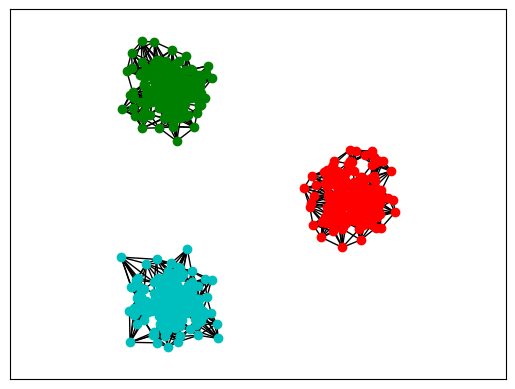

In [20]:
X, Y = blobs(num_samples=600, n_blobs=3)

W = build_similarity_graph(X, k=10)
L = build_laplacian(W, "sym")
Y_rec_spectral = spectral_clustering(L, num_classes=3, chosen_eig_indices=[0, 1, 2])

plot_edges_and_points(X, Y_rec_spectral, W)


### Q2.3: In the function spectral_clustering, implement an automatic strategy to choose the eigenvectors to use for clustering, when chosen_eig_indices=None. Explain your strategy. Generate a dataset with 4 blobs and test your function. What happens when the variance of the blobs increase?

The implemented method is the *eigengap heuristic* mentionned in *A Tutorial on Spectral Clustering*, Ulrike von Luxburg. 

We suppose we know how many clusters we have. Thus, we only want to extract the most meaningful eigenvectors. To do so, 
* we compute the eigengaps between the sorted eigenvalues.
* we extract the index of the last gap above a threshold value. This index is noted $k$.
* we finally select the first $k+1$ eigenvectors.
> Notes: 
> * the threshold value is set at $0.1$
> * this method only works on random walk normalized Laplacian as its eigenvalues are normalized.

Below, we plot the predictions when the cluster are far enough. We still have a connected graph.

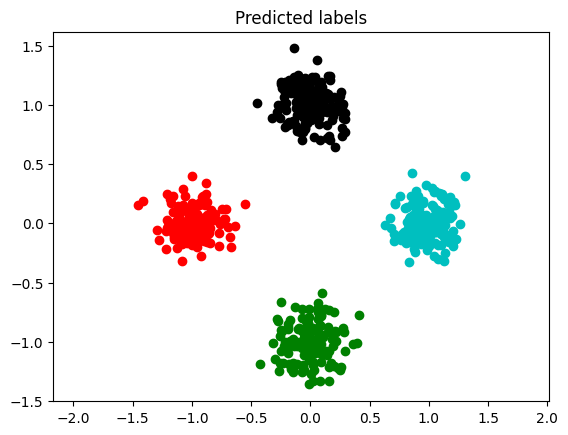

In [21]:
X, Y = blobs(num_samples=600, n_blobs=4, blob_var=0.15)
W = build_similarity_graph(X, eps=0.6)
L = build_laplacian(W, "rw")

Y_rec = spectral_clustering(L, chosen_eig_indices=None, num_classes=4)
plot_edges_and_points_no_edges(X, Y_rec, W, "Predicted labels")



When the variance of the blobs increases, the eigenvalues are smoother and the threshold value $0.1$ needs to be finetuned.

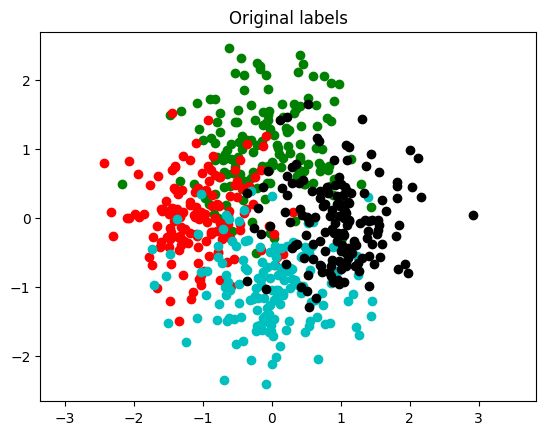

In [23]:
X, Y = blobs(num_samples=600, n_blobs=4, blob_var=0.6)
W = build_similarity_graph(X, eps=0.6)
L = build_laplacian(W, "rw")

Y_rec = spectral_clustering(L, chosen_eig_indices=None, num_classes=4)
plot_edges_and_points_no_edges(X, Y, W, "Original labels")


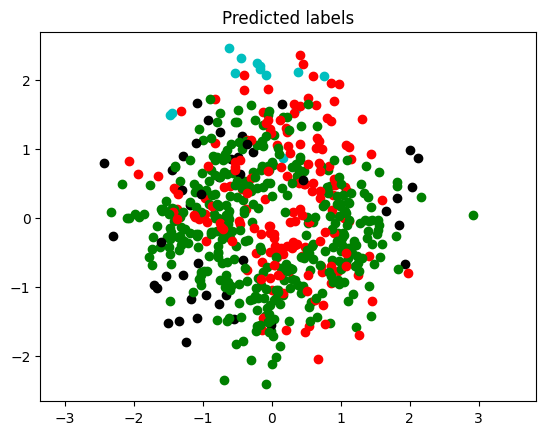

In [24]:
plot_edges_and_points_no_edges(X, Y_rec, W, "Predicted labels")


### Q2.4: When you built the cluster assignment, did you use thresholding, k-means or both? Do you have any opinion on when to use each?

I used both methods. I think the results obtained with $\epsilon$ graphs are often smoother. Running the same experiments multiple times generally leads to the same results. However, there are more complex in space and times. Thus, for the image segmentation, I think it is better to use the $k$-NN method, and a good improvement would be to use sparse array. I used $\epsilon$ graphs when computationnally possible.

### Q2.5: Generate `two_moons` data and compare spectral clustering to k-means. Do you notice any difference? Taking into consideration the graph structure, can you explain them?

Below is the figure comparing spectral clustering and K-Means. We notice that the spectral clustering is performing much better. Indeed, the K-Means will associate nodes to neighbors but this is a too simple relaxation. A node may have close nodes in the 2 differents clusters. Even a connected graph, spectral clustering is able to clusters.

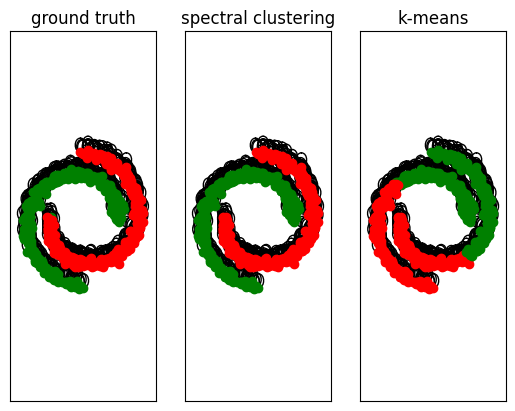

In [26]:
X, Y = two_moons(num_samples=600)
W = build_similarity_graph(X, eps=0.7)
L = build_laplacian(
    W,
)
Y_rec = spectral_clustering(L, num_classes=2, chosen_eig_indices=[1])

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(2, n_init="auto").fit_predict(X))


### Q2.6: Generate `point_and_circle` data and compare spectral clustering using the normal Laplacian and the random-walk regularized Laplacian. Do you notice any difference? Taking into consideration the graph structure, can you explain them?

I notice that the random-walk regularized Laplacian often performs better and over a wider range of hyper-parameters. This can be explained with the associated minimization problems: the standard Laplacian aims at solving RatioCut while the regularized Laplacian aimed at solving the NCut problem. NCut will focus on solutions where the clusters have the same total weight on edges degree. It will encourage within-cluster similarity.

#### Using random-walk regularized Laplacian

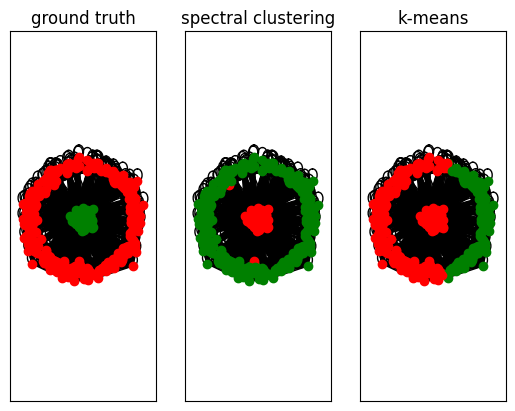

In [27]:
X, Y = point_and_circle(num_samples=600)
W = build_similarity_graph(X, eps=0.25)
L = build_laplacian(W, "rw")
Y_rec = spectral_clustering(L, num_classes=2, chosen_eig_indices=[1])

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(2, n_init="auto").fit_predict(X))



#### Using unnormalized Laplacian

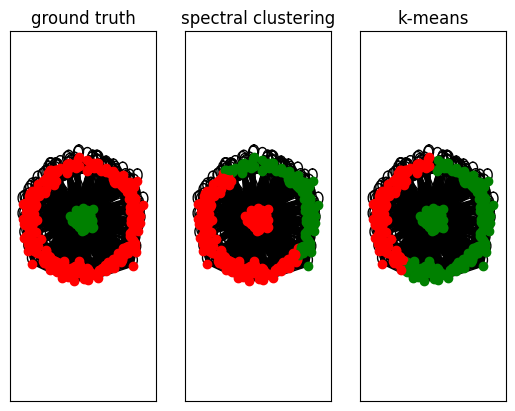

In [28]:
L = build_laplacian(W)
Y_rec = spectral_clustering(L, num_classes=2, chosen_eig_indices=[1])

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(2, n_init="auto").fit_predict(X))


### Q2.7: Using the function parameter_sensitivity, comment on the stability of spectral clustering when varying $\epsilon$ or k. 

We use the `parameter_sensitivity` function to depict the performance of the $\epsilon$ and $k$-NN graphs, with respect to their main parameter.

The following curves were obtained when using the 2nd and 3rd eigenvectors in the clustering. All hyper-parameters are kept the same, in particular, we use the random walk regularized Laplacian on 500 samples. 

First, we notice that in either methods, changing the $\epsilon$ or the $k$ can transform awful results into perfect results. Moreover, the $\epsilon$ graph seems to work on a narrower range of hyper-parameters but its results are smoother. On the contrary, finding a good area of $k$ in $k$-NN graphs seems simpler.

#### $\epsilon$ graph

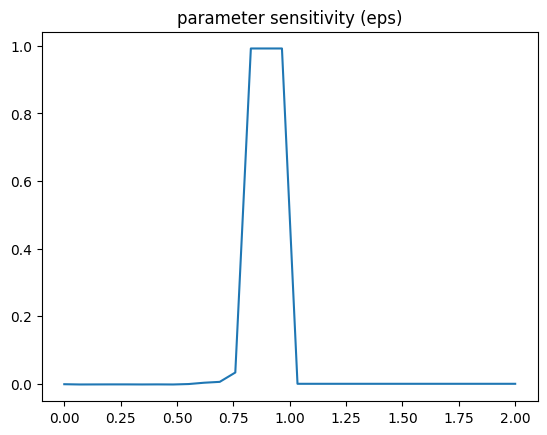

In [29]:
parameter_sensitivity("eps")


$k$-NN graph

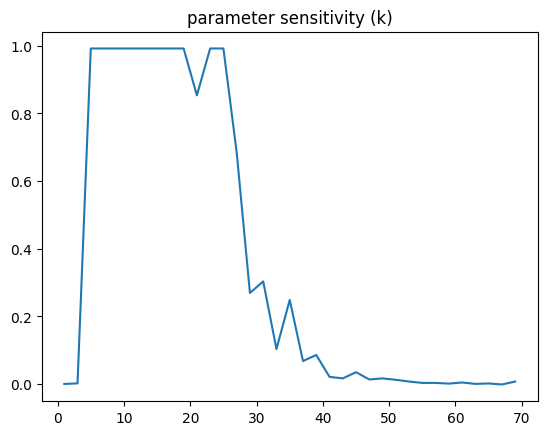

In [30]:
parameter_sensitivity()


### Q2.8: If we did not have access to "true" labels, how could we evaluate the clustering result (or what should we not use as evaluation)?

If we don't have access to the true labels, we won't be able to use the Rand Index. However, there exists other clustering evaluation methods:
* it is important to assess the visual performances of the clustering method. This is even simpler when the data is low dimensional.
* we can use the modularity of the predictions. Considering a specific partition of the network into clusters, modularity measures the number of edges that lie within a cluster compared to the expected number of edges of a random graph with the same degree distribution. It is measured as follow:

    $$
    Q = \sum^{n_c}_c \left[ \frac{l_c}{m} - \left(\frac{d_c}{2m}\right)^2 \right]^2
    $$

    where $m=|E|$ is the total number of edges, $n_c$ is the number of clusters, $l_c$ is the number of edges in the cluster $c$, $d_c$ is the sum of degrees of the nodes in cluster $c$.

### Q3.1: Complete all the code necessary, and cluster the `four_elements` and `fruit_salad` images in the data folder and include here some images of the clustering.  Explain your design choices in the overall pipeline (e.g. which graph, which pre-processing...) and how you think they impact the results you are seeing. Report also at least one failure mode for the algorithm.

Here are the implementation choices I made:
* use a $k$-NN method for a sparse graph
* $k=23$ neighbors work best on the 2 provided images
* `laplacian_normalization="rw"` for smoother results, especially in the homogeneous areas like the background
* we choose the `[1, 2, 3, 4, 5, 6]` eigenvectors for the clustering. We should choose as few eigenvectors as possible, but we also want the results to be smooth.
* the number of clusters is chosen to be an argument of the image segmentation methods. For the ball image, we have 5 clusters (4 balls and the background), while we have only 4 clusters in the fruit image (3 fruits and the background)

> Note: rerunnning the following cells will not provide the same results. Good results are usually found quickly.

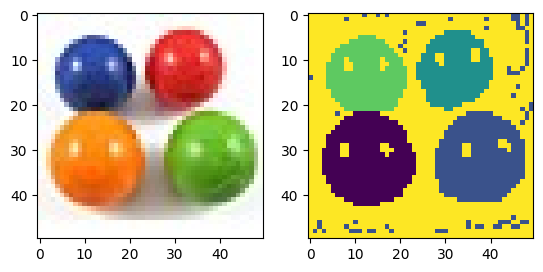

In [33]:
image_segmentation(input_img="four_elements.bmp", num_classes=5)


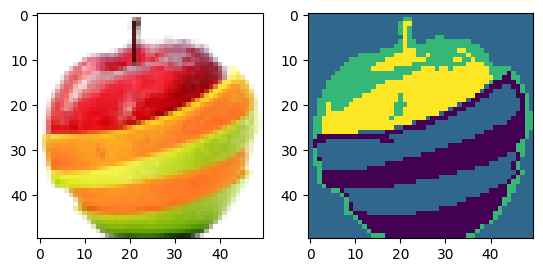

In [34]:
image_segmentation(input_img="fruit_salad.bmp", num_classes=4)


A typical failure mode of the algorithm is that we need to choose the number of clusters. Having more clusters doesn't necessarily means that a cluster will be null, but it creates artefact. For instance, on the fruit image, one could argue that the peduncle is another class. However, when doing so, the result is not as expected. 
Moreover, having RGB images leads to problems in the Euclidian distance: a dark red will be closer to a brown than a light red. As a consequence, the peduncle won't never be recognized as a single class.

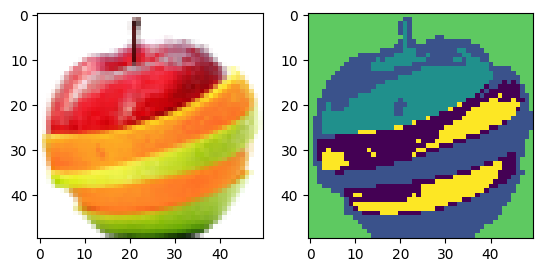

In [35]:
image_segmentation(input_img="fruit_salad.bmp", num_classes=5)


### Q3.2: A full graph built between the pixels of a 50 × 50 image corresponds to $50^2$ nodes. Solving the full eigenvalue problem in this case would scale in the order of $2^{34}$ . Even on weak hardware this takes only seconds to minutes. Segmenting a Full HD picture of 1920 × 1080 would scale in the order of $2^{64}$ (about a month on a decent machine). Beyond that, the large picture would require to store in memory a graph over millions of nodes. A full graph on that scale requires about 1TB of memory. Can you think two simple techniques to reduce the computational and occupational cost of Spectral Clustering?

Simple methods to reduce the computational and occupational cost of the spectral clustering:
* downsample the original image to a smaller size, as $256\times 256$ for instance
* use a $k$-nn graph with sparse implementation to reduce space complexity, as mentionned before
* use `scipy.sparse.linalg.eigsh` to find only the first 15 eigenvalues / eigenvectors of the symmetric and square matrix $L$.

### Q3.3: Choose a larger image of your choice, and try to implement some of the scalability modifications to run spectral clustering on it. Report some examples of the results you achieve. 

We slightly modify the pipeline:
* we load the image and resize it 
* we apply gaussian blur, it improves a bit the results
* we use a k-NN graph, with $k=50$
* we use the `[1, 2]` first eigenvectors for the clustering

Unfortunately, the results are not as good as expected. I am not able to use larger images on my computer.

Building k-NN graph...
Building Laplacian...


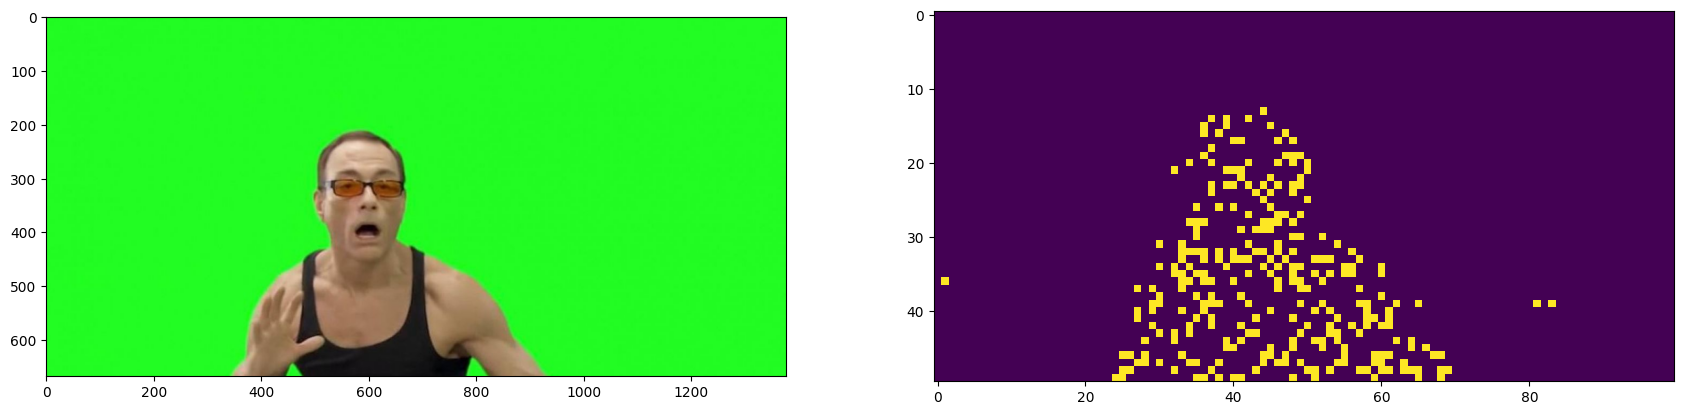

In [42]:
def spectral_clustering_large(L, chosen_eig_indices=None, num_classes=2):
    """
    Parameters
    ----------
    L : numpy array
        Graph Laplacian (standard or normalized)
    choosen_eig_indices : list or None
        Indices of eigenvectors to use for clustering.
        If None, use adaptive choice of eigenvectors.
    num_classes : int
        Number of clusters to compute (defaults to 2)


    Returns
    -------
    Y : numpy array (num_samples, )
        Cluster assignments
    """

    """
    Use the function scipy.linalg.eig or the function scipy.sparse.linalg.eigs to compute:
    U = (n x n) eigenvector matrix           (sorted)
    E = (n x n) eigenvalue diagonal matrix   (sorted)
    """
    E, U = scipy.sparse.linalg.eigsh(L, k=200)
    indices = np.argsort(E.real)
    U = U[:, indices].real
    E = E[indices].real
    """
    compute the clustering assignment from the eigenvectors        
    Y = (n x 1) cluster assignments in [0,1,...,num_classes-1]                   
    """
    # Y = np.zeros(L.shape[0])
    kmeans = KMeans(n_init="auto", n_clusters=num_classes)
    Y = kmeans.fit_predict(U[:, chosen_eig_indices])
    return Y


def image_segmentation_large(
    input_img="four_elements.bmp", num_classes=5
):
    """
    TO BE COMPLETED

    Function to perform image segmentation.

    :param input_img: name of the image file in /data (e.g. 'four_elements.bmp' or 'fruit_salad.bmp')
    """
    import cv2

    filename = os.path.join("data", input_img)
    X = io.imread(filename)

    # im_side = np.size(X, 1)
    # Xr = cv2.cvtColor(X, cv2.COLOR_RGB2GRAY)
    Xr = cv2.resize(X, dsize=(100, int(100 * 0.5)), interpolation=cv2.INTER_LINEAR)
    Xr = cv2.blur(Xr, (5, 5))
    shapes = Xr.shape
    Xr = (Xr - np.min(Xr)) / (np.max(Xr) - np.min(Xr))
    Xr = Xr.reshape(shapes[0] * shapes[1], 3)
    """
    Y_rec should contain an index from 0 to c-1 where c is the     
     number of segments you want to split the image into          
    """

    """
    Choose parameters
    """
    var = 1
    k = 20
    laplacian_normalization = "rw"
    chosen_eig_indices = list(range(0, 3))

    print("Building k-NN graph...")
    W = build_similarity_graph(Xr, var=var, k=k)
    print("Building Laplacian...")
    L = build_laplacian(W, laplacian_normalization)
    L = scipy.sparse.csr_matrix(L)
    Y_rec = spectral_clustering_large(L, chosen_eig_indices, num_classes=num_classes)

    plt.figure(figsize=(21, 8))

    plt.subplot(1, 2, 1)
    plt.imshow(X)

    plt.subplot(1, 2, 2)
    Y_rec = Y_rec.reshape(*shapes[:2])
    plt.imshow(Y_rec)

    plt.show()


image_segmentation_large(input_img="jcvd.jpg", num_classes=2)
